In [189]:
import pandas as pd

df = pd.read_csv('raw_data.csv')

### Аналіз типів даних

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58938 entries, 0 to 58937
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_user             58938 non-null  object 
 1   gender              58938 non-null  object 
 2   date_reg            58938 non-null  object 
 3   platform            58938 non-null  object 
 4   id_traffic_source   58938 non-null  object 
 5   country_group       58938 non-null  int64  
 6   age_group           58938 non-null  int64  
 7   system              58938 non-null  object 
 8   date_payment        10238 non-null  object 
 9   method              10238 non-null  object 
 10  amount              10122 non-null  float64
 11  successful_payment  10238 non-null  float64
 12  split_group         58938 non-null  int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 5.8+ MB


### Переведення стовпців з датами в формат datetime

In [190]:
df['date_reg'] = pd.to_datetime(df['date_reg'])
df['date_payment'] = pd.to_datetime(df['date_payment'])

### Фільтрація: тільки користувачі які зареєструвалися після 24 липня з мобільних пристроїв

In [196]:
filtered = df[(df['platform'] == 'mobile') & (df['date_reg'] >= '2021-07-24 00:00:00')]

### Фільтрація успішних платежів після початку тесту

In [197]:
payments = filtered[(filtered['successful_payment'] == 1) & (filtered['date_payment'] >= '2021-07-24')]

### Перевірка пропущених значень

In [199]:
print(payments.isnull().sum())

id_user               0
gender                0
date_reg              0
platform              0
id_traffic_source     0
country_group         0
age_group             0
system                0
date_payment          0
method                0
amount                0
successful_payment    0
split_group           0
dtype: int64


### Кількість користувачів у кожній групі

In [200]:
users_per_group = filtered.groupby('split_group')['id_user'].nunique()
print("Кількість користувачів у групах:")
print(users_per_group)

Кількість користувачів у групах:
split_group
0    5877
1    5915
Name: id_user, dtype: int64


### Кількість успішних оплат у кожній групі

In [195]:
successful_payments = payments.groupby('split_group')['id_user'].count()
print("\nКількість успішних оплат у групах:")
print(successful_payments)


Кількість успішних оплат у групах:
split_group
0    665
1    669
Name: id_user, dtype: int64


### Кількість платників

In [170]:
successful_users = payments.groupby('split_group')['id_user'].nunique()
print("\nКількість платників:", successful_users)


Кількість платників: split_group
0    171
1    171
Name: id_user, dtype: int64


### Конверсія у групах

In [171]:
conversion_rate = successful_users / users_per_group * 100
print("\nКонверсія (%) у кожній групі:")
print(conversion_rate)


Конверсія (%) у кожній групі:
split_group
0    2.909648
1    2.890955
Name: id_user, dtype: float64


### Середній чек

In [172]:
avg_payment = payments.groupby('split_group')['amount'].mean()
print("\nСередня сума платежу:")
print(avg_payment)


Середня сума платежу:
split_group
0    131.010835
1    164.689791
Name: amount, dtype: float64


### Середній дохід на користувача

In [173]:
total_revenue = payments.groupby('split_group')['amount'].sum()
arpu = total_revenue / users_per_group
print("\nTotal Revenue:\n", total_revenue)
print("\nARPU:\n", arpu)


Total Revenue:
 split_group
0     87122.205
1    110177.470
Name: amount, dtype: float64

ARPU:
 split_group
0    14.824265
1    18.626791
dtype: float64


### Z-test для конверсії

In [174]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def z_test(success1, n1, success2, n2):
    p1, p2 = success1/n1, success2/n2
    p = (success1 + success2) / (n1 + n2)
    se = np.sqrt(p * (1 - p) * (1/n1 + 1/n2))
    z = (p1 - p2) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p_value

z, p_value = z_test(successful_users.get(1, 0), users_per_group.get(1, 0),
                   successful_users.get(0, 0), users_per_group.get(0, 0))
print(f"\nZ-тест для конверсії: z = {z:.2f}, p = {p_value:.4f}")
if p_value < 0.05:
    print("Різниця в конверсії статистично значуща. Рекомендується впровадити новий дизайн.")
else:
    print("Різниця в конверсії не є статистично значущою. Потрібен додатковий аналіз.")


Z-тест для конверсії: z = -0.06, p = 0.9518
Різниця в конверсії не є статистично значущою. Потрібен додатковий аналіз.


### T-test для перевірки середнього платежу у групах

In [175]:
test_payments = df[(df['split_group'] == 1) & (df['successful_payment'] == 1)]['amount']
control_payments = df[(df['split_group'] == 0) & (df['successful_payment'] == 1)]['amount']

t, p = stats.ttest_ind(test_payments, control_payments, equal_var=False)
print(f't-value = {t:.2f}')
print(f'p-value = {p:.4f}')

t-value = 7.15
p-value = 0.0000


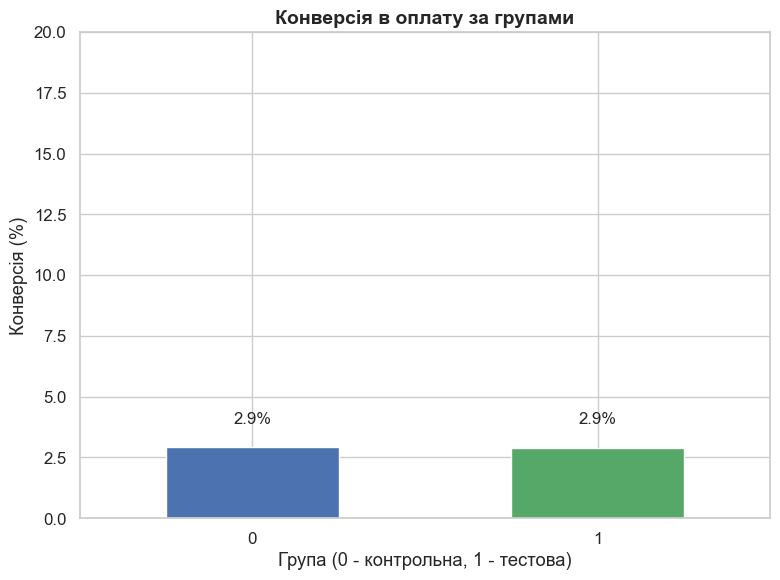

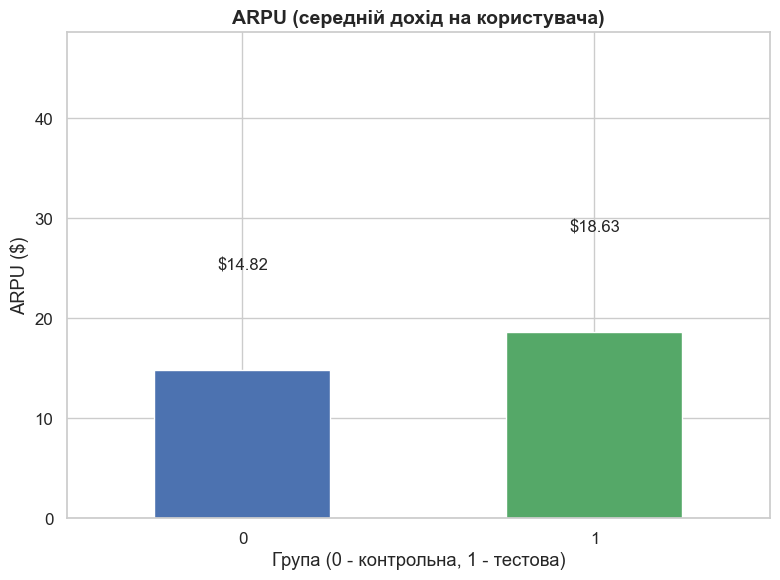

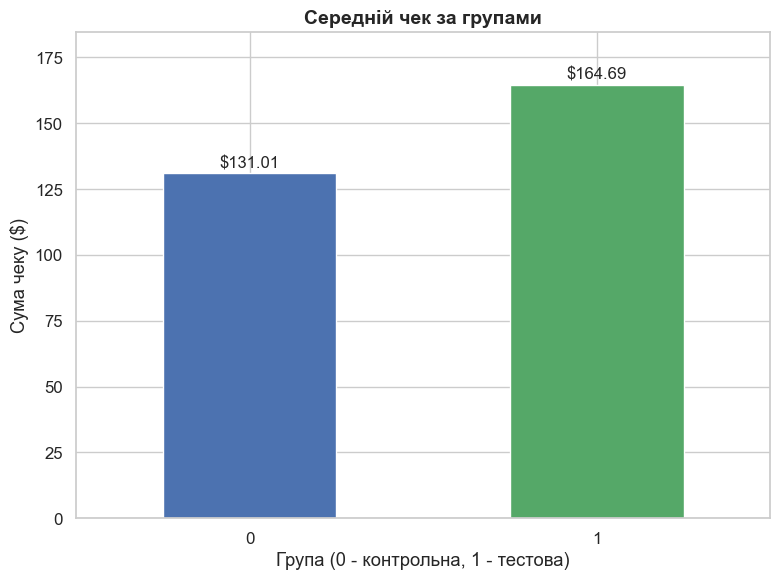

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.1)

colors = ['#4C72B0', '#55A868']

plt.figure(figsize=(8, 6))
ax = conversion_rate.plot(kind='bar', color=colors)
plt.title('Конверсія в оплату за групами', fontsize=14, weight='bold')
plt.xlabel('Група (0 - контрольна, 1 - тестова)')
plt.ylabel('Конверсія (%)')
plt.xticks(rotation=0)
for i, val in enumerate(conversion_rate.values):
    plt.text(i, val + 1, f"{val:.1f}%", ha='center', fontsize=12)
plt.ylim(0, max(conversion_rate.max(), 10) + 10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
ax = arpu.plot(kind='bar', color=colors)
plt.title('ARPU (середній дохід на користувача)', fontsize=14, weight='bold')
plt.xlabel('Група (0 - контрольна, 1 - тестова)')
plt.ylabel('ARPU ($)')
plt.xticks(rotation=0)
for i, val in enumerate(arpu.values):
    plt.text(i, val + 10, f"${val:.2f}", ha='center', fontsize=12)
plt.ylim(0, arpu.max() + 30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
ax = avg_payment.plot(kind='bar', color=colors)
plt.title('Середній чек за групами', fontsize=14, weight='bold')
plt.xlabel('Група (0 - контрольна, 1 - тестова)')
plt.ylabel('Сума чеку ($)')
plt.xticks(rotation=0)
for i, val in enumerate(avg_payment.values):
    plt.text(i, val + 2, f"${val:.2f}", ha='center', fontsize=12)
plt.ylim(0, avg_payment.max() + 20)
plt.tight_layout()
plt.show()